## IBM Capstone Project - Opening a Pizza Place

A young enterpreneur likes to open up a Pizza Place in Toronto as Pizza has for a long time and still is a very popular food all over the world. In this project, I will find out the best neighborhood in Toronto for him to open a new Pizza Place to help him in decision making. This is done by using the following methods:

- Using multiple datasets from different sources (i.e. Web, Geocode, CSV files, Foursquare API)
- Python Webscraping using Beautifulsoup
- Data Preprocessing
- Data Analysis


In [1]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed')

Packages installed


In [3]:
# Obtain neighbourhood data using beautiful soup 
url= 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['PostalCode', 'Borough', 'Neighbourhood']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)

df = pd.DataFrame.from_dict(data=data)[columns]
print(df.shape)
df.head(7)

(180, 3)


,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In a next step the "Not assigned" in  "Borough" will be removed

In [4]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

To simplify variable indexing in the next step renaming is done as following:  _**Postal Code**_ to _**PostalCode**_ 

In [5]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [6]:
df = df_dropna

In [8]:
df.head(6)

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"


Now data is grouped by "Borough"

In [9]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head(6)

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest..."


Rearrangement of data so that PostalCode is in the first column


In [50]:
df = df_grouped
df = df[['PostalCode', 'Borough', 'Neighbourhood']]
df.shape
df.head(6)

,PostalCode,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"
5,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest..."


Now the Latitudes and Longitudes for to the different PostalCodes are obtained 

In [138]:
geo_url = "https://cocl.us/Geospatial_data"
geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head(2)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497


In the next step data is merged in DataFrame df.

In [52]:
# Merging the Data
df_toronto = pd.merge(df, geo_df, on='PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [53]:
# count neighbourhoods for the different boroughs in Toronto
df_toronto.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
Toronto/York         1
West Toronto         6
York                 4
Name: Neighbourhood, dtype: int64

In [54]:
df_toronto.head(3)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678


In [55]:
#Create list with the Boroughs 
boroughs = df_toronto['Borough'].unique().tolist()
boroughs

['Central Toronto',
 'Downtown Toronto',
 'East Toronto',
 'East York',
 'Etobicoke',
 'Mississauga',
 'North York',
 'Scarborough',
 'Toronto/York',
 'West Toronto',
 'York']

In [58]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('Geographical coordinates of Toronto: {}, {}'.format(lat_toronto, lon_toronto))

Geographical coordinates of Toronto: 43.70460773398059, -79.39715291165047


In [73]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [75]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighbourhood
    #label = folium.Popup(label_text)    #diese Zeile macht Probleme !!!
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
map_toronto

## FourSquare

In [139]:
#log in
CLIENT_ID = 'M03GOJIUNHXLBHCNPUXOKT2BBBNUEI0LWOEMOKROXCZKPMPH' # your Foursquare ID
CLIENT_SECRET = 'VPZIU2ODLUODYMOL4NLMC2MAJUOX14YWBLYMIIEZKWO2Z2RH' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


#### Obtain TOP 100 venues within a radius of 500 m

Define the GET request URL

In [140]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return  relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter

In [141]:
toronto_venues.tail(12)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2109,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Tennis Courts,43.692744,-79.432244,Tennis Court
2110,Humewood-Cedarvale,43.693781,-79.428191,Phil White Arena,43.691303,-79.431761,Hockey Arena
2111,Caledonia-Fairbanks,43.689026,-79.453512,Nairn Park,43.690654,-79.456300,Park
2112,Caledonia-Fairbanks,43.689026,-79.453512,Maximum Woman,43.690651,-79.456333,Women's Store
2113,Caledonia-Fairbanks,43.689026,-79.453512,Fairbanks Pool,43.691959,-79.448922,Pool
2114,Caledonia-Fairbanks,43.689026,-79.453512,Fairbank Memorial Park,43.692028,-79.448924,Park
2115,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,Subway,43.690218,-79.474050,Sandwich Place
2116,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,Dollar Tree,43.690296,-79.474667,Discount Store
2117,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,Dave's Chicken,43.690173,-79.474234,Fried Chicken Joint
2118,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,McDonald's,43.692926,-79.479982,Fast Food Restaurant


Obtain number of venues per neighborhood

In [81]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


### Number of unique venues in Toronto

In [82]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


In [83]:
print("Venue Categories are", toronto_venues['Venue Category'].unique())

Venue Categories are ['Park' 'Swim School' 'Bus Line' 'Food & Drink Shop' 'Breakfast Spot'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym / Fitness Center'
 'Convenience Store' 'Gym' 'Yoga Studio' 'Salon / Barbershop' 'Restaurant'
 'Spa' 'Mexican Restaurant' 'Chinese Restaurant' 'Diner' 'Clothing Store'
 'Coffee Shop' 'Fast Food Restaurant' 'Sporting Goods Shop' 'Café'
 'Seafood Restaurant' 'Gift Shop' 'Ice Cream Shop' 'Dessert Shop'
 'Indian Restaurant' 'Pizza Place' 'Sushi Restaurant' 'Italian Restaurant'
 'Thai Restaurant' 'Brewery' 'Greek Restaurant' 'Toy / Game Store'
 'Gas Station' 'Farmers Market' 'Gourmet Shop' 'Pharmacy' 'Movie Theater'
 'Indoor Play Area' 'Tennis Court' 'Supermarket' 'Liquor Store'
 'American Restaurant' 'Pub' 'Bank' 'Fried Chicken Joint'
 'Vietnamese Restaurant' 'Light Rail Station' 'Bagel Shop' 'Home Service'
 'Garden' 'Trail' 'Jewelry Store' 'Burger Joint' 'BBQ Joint'
 'Middle Eastern Restaurant' 'Donut Shop' 'History Museum' 'Grocery Store'
 'Playgroun

### One hot encoding

In [96]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column to dataframe
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2121, 270)


,Neighbourhoods,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [97]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()
print(to_grouped.shape)
to_grouped.head()

(95, 270)


,Neighbourhoods,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
ita = to_grouped[["Neighbourhoods","Pizza Place"]]
ita = ita.rename(columns={'Neighbourhoods':'Neighbourhood'})
ita.head() #.head() shows the first five rows only

,Neighbourhood,Pizza Place
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.222222
2,"Bathurst Manor, Wilson Heights, Downsview North",0.045455
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.043478



## Cluster  neighbourhoods
using k-means clustering. But first we will find the best _K_ using the **Elbow Point** method.

In [110]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighbourhood'], axis=1)

In [111]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [112]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [113]:
scores = [get_inertia(x) for x in range(2, 12)]

Text(0, 0.5, 'error')

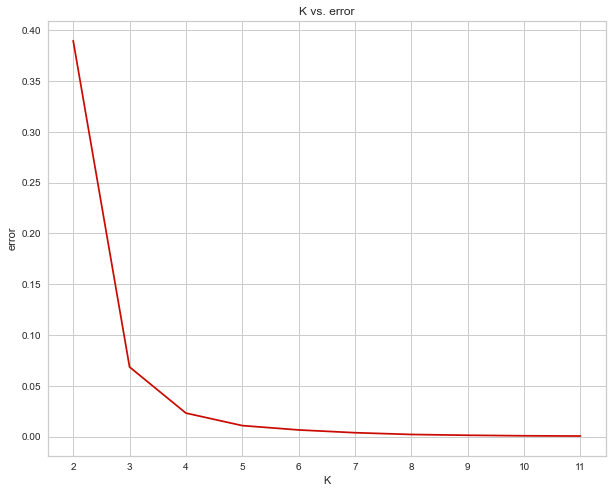

In [114]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 12), y=scores, color='r')
plt.title("K vs. error")
plt.xticks(range(2, 12))
plt.xlabel("K")
plt.ylabel("error")

In [37]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install yellowbrick


In [115]:
from yellowbrick.cluster import KElbowVisualizer

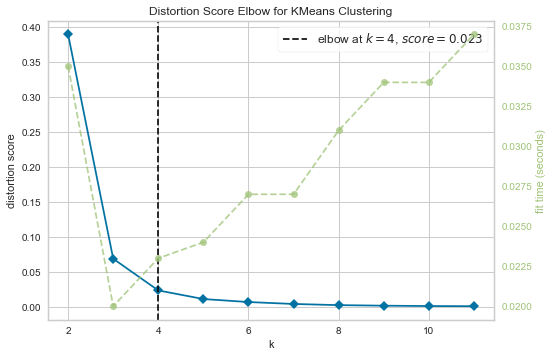

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [116]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()     

We see that the optimum K value is 4 so we will have a resulting of 4 clusters

In [117]:
kclusters = 4
toronto_grouped_clustering = ita.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 3, 0, 3, 0, 0, 0, 3, 0])

In [118]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()
# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [119]:
to_merged.head()

,Neighbourhood,Pizza Place,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.222222,2
2,"Bathurst Manor, Wilson Heights, Downsview North",0.045455,3
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.043478,3


In [120]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")
print(to_merged.shape)
to_merged.head()

(2121, 9)


,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.000000,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.000000,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.000000,0,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
1,"Alderwood, Long Branch",0.222222,2,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [121]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2121, 9)


,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.00,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
59,"Parkdale, Roncesvalles",0.00,0,43.648960,-79.456325,La Cubana,43.650912,-79.450909,Cuban Restaurant
59,"Parkdale, Roncesvalles",0.00,0,43.648960,-79.456325,The Chocolateria,43.649928,-79.450437,Dessert Shop
59,"Parkdale, Roncesvalles",0.00,0,43.648960,-79.456325,Offleash Dog Trail - High Park,43.645485,-79.458747,Dog Run
58,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.00,0,43.636258,-79.498509,Woodford Park,43.633152,-79.496266,Baseball Field
...,...,...,...,...,...,...,...,...,...
78,"The Annex, North Midtown, Yorkville",0.05,3,43.672710,-79.405678,Pour House,43.675641,-79.403821,Pub
78,"The Annex, North Midtown, Yorkville",0.05,3,43.672710,-79.405678,Krispy Kreme Doughnut Cafe,43.674732,-79.407730,Donut Shop
78,"The Annex, North Midtown, Yorkville",0.05,3,43.672710,-79.405678,Dish Cooking Studio,43.674066,-79.410764,Café
78,"The Annex, North Midtown, Yorkville",0.05,3,43.672710,-79.405678,Tim Hortons,43.675800,-79.403532,Coffee Shop


Lets check how many Pizza Places are there

In [122]:
to_merged['Venue Category'].value_counts()['Pizza Place']

48

We see that there are a total of **48** Pizza Places in Toronto and now create a new dataframe with the Neighborhood and Pizza Places.

In [126]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## How many Neighbourhoods per Cluster?


In [127]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

,Neighbourhood,Pizza Place,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.222222,2
2,"Bathurst Manor, Wilson Heights, Downsview North",0.045455,3
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.043478,3


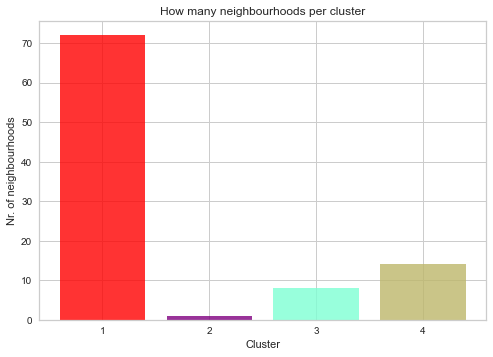

In [143]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Nr. of neighbourhoods')
plt.xlabel('Cluster')
plt.title('How many neighbourhoods per cluster')

plt.show()

In [129]:
# How many neighbourhoods in each cluster
ita['Cluster Labels'].value_counts()

0    72
3    14
2     8
1     1
Name: Cluster Labels, dtype: int64

## Analysis of clusters

### Cluster #1

In [152]:
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

,Borough,Neighbourhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


In [154]:
# Cluster 1 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
df_cluster1.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
1,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
3,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,900 Mount Pleasant - Residents Gym,43.711671,-79.391767,Gym / Fitness Center
4,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place


### Cluster #2

In [155]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')

In [156]:
df_cluster2.sort_values(["Pizza Place"], ascending=False)

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Humber Summit,1.0,1,43.756303,-79.565963,Pizza Monza,43.755043,-79.567195,Pizza Place


In [157]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Pizza Place']


1

### Cluster #3

In [159]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
df_cluster3.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East York,"Parkview Hill, Woodbine Gardens",0.166667,2,43.706397,-79.309937,Jawny Bakers,43.705783,-79.312913,Gastropub
1,East York,"Parkview Hill, Woodbine Gardens",0.166667,2,43.706397,-79.309937,Shoppers Drug Mart,43.705933,-79.312825,Pharmacy
2,East York,"Parkview Hill, Woodbine Gardens",0.166667,2,43.706397,-79.309937,TD Canada Trust,43.705740,-79.312270,Bank
3,East York,"Parkview Hill, Woodbine Gardens",0.166667,2,43.706397,-79.309937,Pizza Pizza,43.705159,-79.313130,Pizza Place
4,East York,"Parkview Hill, Woodbine Gardens",0.166667,2,43.706397,-79.309937,Rise & Dine Eatery,43.705769,-79.311638,Breakfast Spot


### Cluster #4

In [161]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
df_cluster4.head(3)

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,Davisville,0.138889,3,43.704324,-79.38879,Second Cup,43.704344,-79.388659,Coffee Shop
1,Central Toronto,Davisville,0.138889,3,43.704324,-79.38879,Petro-Canada,43.702269,-79.387955,Gas Station
2,Central Toronto,Davisville,0.138889,3,43.704324,-79.38879,Mastermind Toys,43.704839,-79.388546,Toy / Game Store


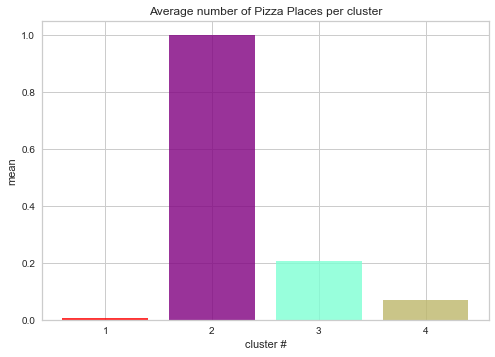

In [162]:
clusters_mean = [df_cluster1['Pizza Place'].mean(),df_cluster2['Pizza Place'].mean(),df_cluster3['Pizza Place'].mean(),
                 df_cluster4['Pizza Place'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('mean')
plt.xlabel('cluster #')
plt.title('Average number of Pizza Places per cluster')

plt.show()